In [5]:
#Imports

from sklearn import tree
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import model_selection
from pprint import pprint
from matplotlib.pyplot import scatter 
import pandas as pd
import warnings
import sys
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [6]:
#Data filtering functions (gets rid of lines containing the same scores for all configurations & badly shaped data)

def data_filter(data):
    for line in data:
        if len(line)!=17:
            data.remove(line)
        else:
            configScores=line[-5:]
            if (configScores.count(configScores[0]) == len(configScores)):
                data.remove(line)
    return data
       

In [7]:
#Importing Data from file
dataset = np.genfromtxt("all-data-filtered", delimiter='')

#Input
Input = dataset[:, :-8]
print(np.array(Input))
#Features
features_file = open("Data-Extraction/features", "r")
features = features_file.readlines()

#Applying scaling
sc = StandardScaler()
Input = sc.fit_transform(Input)

[[    2.   67479.    1831.   ...     0.03     0.       0.11]
 [    2.   82185.    2309.   ...     0.03     0.       0.11]
 [    2.    1918.      18.   ...     0.01     0.       0.01]
 ...
 [    2.    5131.      81.   ...     0.02     0.       0.09]
 [    2.    6302.      96.   ...     0.02     0.       0.09]
 [    2.   13894.     402.   ...     0.03     0.       0.11]]


In [8]:
Outputs=[]

for i in range(0,8):
    Output=dataset[:, i-8]
    Outputs.append(Output)
    

In [9]:
import time
import random

#Function that, given a configuration, outputs a table summarizing the best parameters to consider for that configuration
#Note: c is the configuration number: goes from 0 to 7

def tableConfig(c):
    
    hidden_layer_sizes=[(100,),(250,400)]
    activation=['identity','logistic']
    early_stopping =[False,True]
    max_iter=[1000,2500]
    
    max=-sys.maxsize - 1
    Output=Outputs[c]
    
    x_train, x_test, y_train, y_test = model_selection.train_test_split(Input, Output, random_state=1, test_size = 0.20)    
    for i in hidden_layer_sizes: 
        for j in activation: 
            for k in early_stopping:   
                for n in max_iter:
                                
                    mlp = MLPRegressor(
                        hidden_layer_sizes=i,
                        activation= j,
                        early_stopping = k,
                        validation_fraction=0.1,
                        n_iter_no_change=100,
                        max_iter= n, 
                        learning_rate_init=0.01            
                                )
                    mlp.fit(x_train, y_train)
                    
                    if max<mlp.score(x_test, y_test):
                        max=mlp.score(x_test, y_test)
                        bestLayers=i
                        bestActivation=j
                        bestStopping=k
                        bestIter=n         
                        
    bestConfig=[bestLayers,bestActivation,bestStopping,0.1,100,bestIter,0.01]                            
    return bestConfig

In [10]:
treeConfigs=[]

for i in range(0,8):
    treeConfigs.append(tableConfig(i))



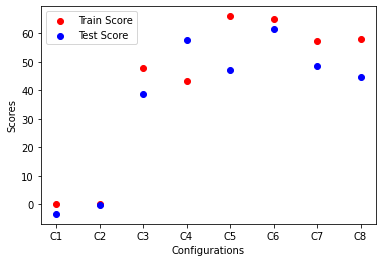

8.949314384285568 %


In [12]:
Configs=[]
trainScores=[]
testScores=[]
xTrain=[]
yTrain=[]
xTest=[]
yTest=[]
Gaps=[]
Trees=[]
gap=0
mlps=[]

#Collecting Trains & Test vectors for MLP Regressor Evaluation
for i in range(1,9):
    Configs.append("C"+str(i))
    Output=dataset[:,i-9]
    
    #Data splitting: training set & test set: 20% | 80%
    x_train, x_test, y_train, y_test = model_selection.train_test_split(Input, Output, random_state=1, test_size = 0.20)
    x_test, x_validation, y_test, y_validation = model_selection.train_test_split(x_test, y_test, test_size=0.25, random_state=42)
    xTrain.append(x_train)
    yTrain.append(y_train)
    xTest.append(x_test)
    yTest.append(y_test)
    
for i in range(0,8):
    mlp = MLPRegressor(
    hidden_layer_sizes=treeConfigs[i][0],
    activation= treeConfigs[i][1],
    early_stopping=treeConfigs[i][2],
    validation_fraction=treeConfigs[i][3],
    n_iter_no_change=treeConfigs[i][4],
    max_iter= treeConfigs[i][5], 
    learning_rate_init=treeConfigs[i][6] 
    )
    
    #Training
    mlp.fit(xTrain[i], yTrain[i])
    
    #Evaluation
    trainScores.append(mlp.score(xTrain[i], yTrain[i])*100)
    testScores.append(mlp.score(xTest[i], yTest[i])*100)
    gap+=abs((mlp.score(xTrain[i], yTrain[i])-mlp.score(xTest[i], yTest[i]))*100)
    mlps.append(mlp)
    
gap/=len(Configs)
scatter(Configs,trainScores,c='red',label='Train Score')
scatter(Configs,testScores,c='blue',label='Test Score')
plt.xlabel("Configurations")
plt.ylabel("Scores")
plt.legend()
plt.show()

print(gap,"%")
Gaps.append(gap)

In [13]:
import array

for i in range(0,8):
    print(mlps[i].predict(np.reshape([2, 82185, 2309, 0, 87536, 9671, 0.03, 0, 0.11],(1, -1))))

[80.56747257]
[81.98684182]
[32.69571065]
[51.9165224]
[3.34188028]
[-2.52998862]
[55.8491175]
[18.56772605]


In [14]:
def best_config(instance):
    scores=[]
    for i in range(0,8):
        scores.append(mlps[i].predict(np.reshape(instance,(1, -1))))
    return "Best configuration for this instance in Configuration "+str(scores.index(max(scores))+1)

In [15]:
best_config([2, 18555, 1341, 0, 19260, 61, 0.07, 0, 0])

'Best configuration for this instance in Configuration 2'